# MAST30034 Project 1
## Analysis

In [1]:
from functools import reduce 
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/10 10:49:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pandas as pd
import geopandas as gpd
import folium

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Geopandas visualisation
#### Average tip earnings per taxi zone

In [3]:
sf = gpd.read_file("../../Project 1/Data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../../Project 1/Data/taxi_zones/taxi+_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()


In [4]:
sdf = spark.read.parquet('processed')
geo_tips = sdf[['pickup_location', 'tip_amount']] \
                .groupby('pickup_location') \
                .agg(
                    {
                        'tip_amount': 'sum', # sum over total amount earned
                        'pickup_location': 'count' # count number of instances from sample
                    }
                )
geo_tips = geo_tips.withColumn('avg_tip_amount', geo_tips['sum(tip_amount)'] / geo_tips['count(pickup_location)'])
geo_tips = geo_tips.withColumnRenamed('count(pickup_location)', 'total_trips').withColumnRenamed('sum(tip_amount)', 'total_tips')
df = geo_tips.toPandas()
df = df \
    .merge(gdf[['LocationID', 'geometry']], left_on='pickup_location', right_on='LocationID') \
    .drop('LocationID', axis=1)

In [5]:
map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='Average Tip Earnings (USD)', # name of plot
    data=df, # data source
    columns=['pickup_location','avg_tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tip Earnings (USD)'
)
c.add_to(map)
map.save("/outputs/Average_tip_amount.html")

In [6]:
df['avg_tip_amount'].idxmax()
df.loc[[103]]
df = df.drop(103)

In [7]:
map = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='Average Tip Earnings (USD) (outlier removed)', # name of plot
    data=df, # data source
    columns=['pickup_location','avg_tip_amount'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Average Tip Earnings (USD)'
)
c.add_to(map)
map.save("/outputs/Average_tip_amount_drop_outlier.html")

### Comparing fare amount to tips given

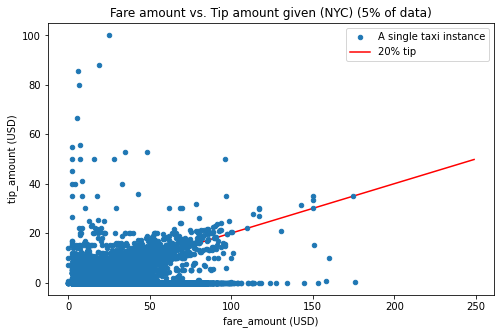

In [28]:
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df = df.sample(frac=0.05, replace=True, random_state=1)
x = df['fare_amount']
y = df['tip_amount']
line = range(250)
x_line = [0.2*x for x in range(250)]
fig, ax = plt.subplots(figsize=(8,5))
fare_df = pd.DataFrame({"x": x, "y":y})
#You pass the wanted axis to the ax argument
fare_df.plot(kind='scatter', x= 'x', y= 'y', title="Fare amount vs. Tip amount given (NYC) (5% of data)", ax=ax) 
ax.plot(line, x_line, zorder=-1, color = 'r')
ax.set_xlabel("fare_amount (USD)")
ax.set_ylabel("tip_amount (USD)")
plt.legend(['A single taxi instance', '20% tip'])

### Frequency of particular tip amounts

Text(0.5, 0, 'tip_amount (USD)')

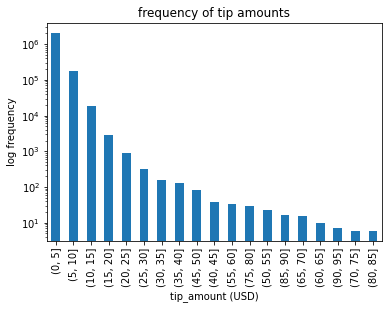

In [35]:
import pandas as pd
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df['binned'] = pd.cut(df["tip_amount"], bins= range(0, 100, 5))
ax = df['binned'].value_counts().plot(kind='bar', logy = True, title = 'frequency of tip amounts')
ax.set_ylabel("log frequency")
ax.set_xlabel("tip_amount (USD)")

In [41]:
pctge_non_zero_tips = round(((df['tip_amount'] == 0).sum() / df['tip_amount'].count())*100, 3)
pctge_non_zero_tips

34.22

# ==========Keep looking at relationships between tips and x=============

In [24]:
df = pd.read_parquet("../../Project 1/DataFrames/stats_modelling")
df

,pickup_location,dropoff_location,passenger_count,fare_amount,tip_amount,total_amount,payment_type,surcharge_amount,trip_distance_km,trip_time_min,pickup_date,temp,dew_point,pressure,wind_speed,wind_direction
0,77,77,1,12.0,0.00,13.30,1,1.30,4.699,14.267,2018-03-01,100.5,28.299999,10111.299805,21.299999,320.299988
1,127,127,2,35.5,8.50,51.06,1,7.06,19.312,24.650,2018-03-01,100.5,28.299999,10111.299805,21.299999,320.299988
2,65,65,5,14.0,3.06,18.36,1,1.30,6.325,14.683,2018-03-01,100.5,28.299999,10111.299805,21.299999,320.299988
3,255,255,1,6.0,0.00,7.30,1,1.30,2.237,4.917,2018-03-01,100.5,28.299999,10111.299805,21.299999,320.299988
4,112,112,1,23.0,0.00,24.30,1,1.30,11.475,20.383,2018-03-01,100.5,28.299999,10111.299805,21.299999,320.299988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3435452,244,244,1,40.5,7.19,55.11,1,7.42,23.512,25.533,2019-12-31,72.5,14.872414,10055.079102,49.320690,172.458618
3435453,74,74,1,4.5,5.00,10.80,1,1.30,1.497,3.117,2019-12-31,72.5,14.872414,10055.079102,49.320690,172.458618
3435454,255,255,1,22.0,3.50,28.75,1,1.30,10.380,20.700,2019-12-31,72.5,14.872414,10055.079102,49.320690,172.458618
3435455,61,61,1,15.5,5.04,21.84,1,1.30,6.067,19.017,2019-12-31,72.5,14.872414,10055.079102,49.320690,172.458618


In [ ]:
x = df['fare_amount']
y = df['tip_amount']
line = range(250)
x_line = [0.2*x for x in range(250)]
fig, ax = plt.subplots(figsize=(8,5))
df = pd.DataFrame({"x": x, "y":y})
#You pass the wanted axis to the ax argument
df.plot(kind='scatter', x= 'x', y= 'y', title="Fare amount vs. Tip amount given (NYC)", ax=ax) 